Train data shape: (20600, 13), covering dates: 2016-01-01 00:00:00 to 2024-07-01 00:00:00
Test data shape: (400, 13), covering dates: 2024-08-01 00:00:00 to 2024-09-01 00:00:00
Epoch [5/50], Loss: 0.0010
Epoch [10/50], Loss: 0.0009
Epoch [15/50], Loss: 0.0007
Epoch [20/50], Loss: 0.0007
Epoch [25/50], Loss: 0.0005
Epoch [30/50], Loss: 0.0004
Epoch [35/50], Loss: 0.0004
Epoch [40/50], Loss: 0.0004
Epoch [45/50], Loss: 0.0004
Epoch [50/50], Loss: 0.0003


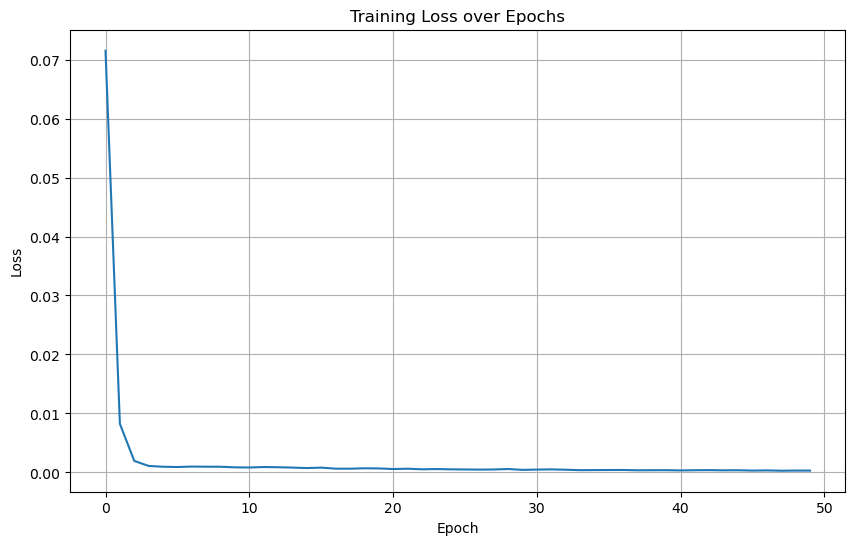


Test Set Performance:
MSE: 18509460385948228.00
MAE: 10914185.64
Spearman Rank Correlation: 0.8967


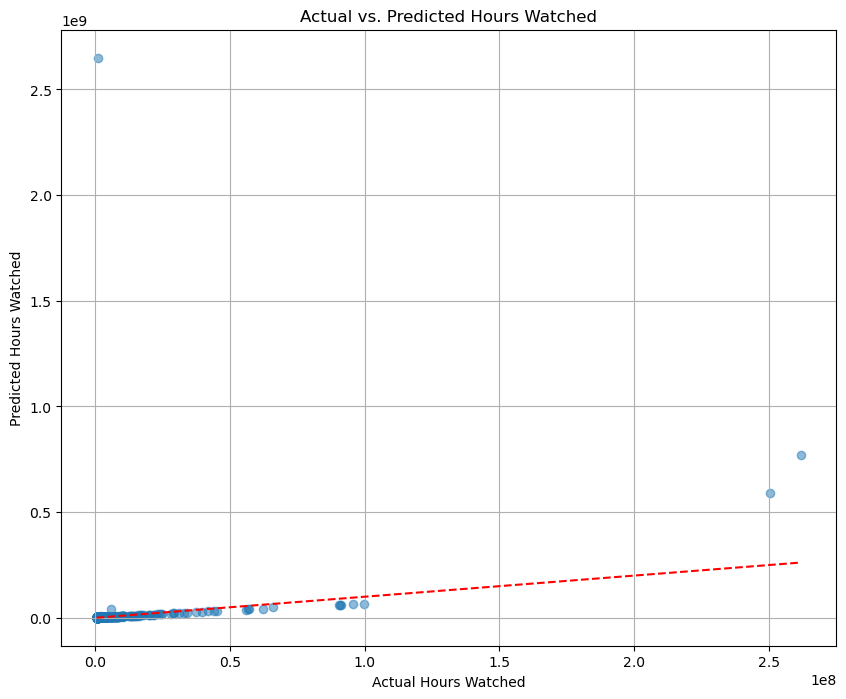


Performance for August 2024:
Top-10 Games:
  Overlap: 80.00% (8 out of 10)
  Precision: 80.00%
  Recall: 80.00%
  F1 Score: 80.00%
Top-50 Games:
  Overlap: 92.00% (46 out of 50)
  Precision: 92.00%
  Recall: 92.00%
  F1 Score: 92.00%
Top-100 Games:
  Overlap: 86.00% (86 out of 100)
  Precision: 86.00%
  Recall: 86.00%
  F1 Score: 86.00%
Top-200 Games:
  Overlap: 100.00% (200 out of 200)
  Precision: 100.00%
  Recall: 100.00%
  F1 Score: 100.00%

Performance for September 2024:
Top-10 Games:
  Overlap: 100.00% (10 out of 10)
  Precision: 100.00%
  Recall: 100.00%
  F1 Score: 100.00%
Top-50 Games:
  Overlap: 90.00% (45 out of 50)
  Precision: 90.00%
  Recall: 90.00%
  F1 Score: 90.00%
Top-100 Games:
  Overlap: 86.00% (86 out of 100)
  Precision: 86.00%
  Recall: 86.00%
  F1 Score: 86.00%
Top-200 Games:
  Overlap: 100.00% (200 out of 200)
  Precision: 100.00%
  Recall: 100.00%
  F1 Score: 100.00%


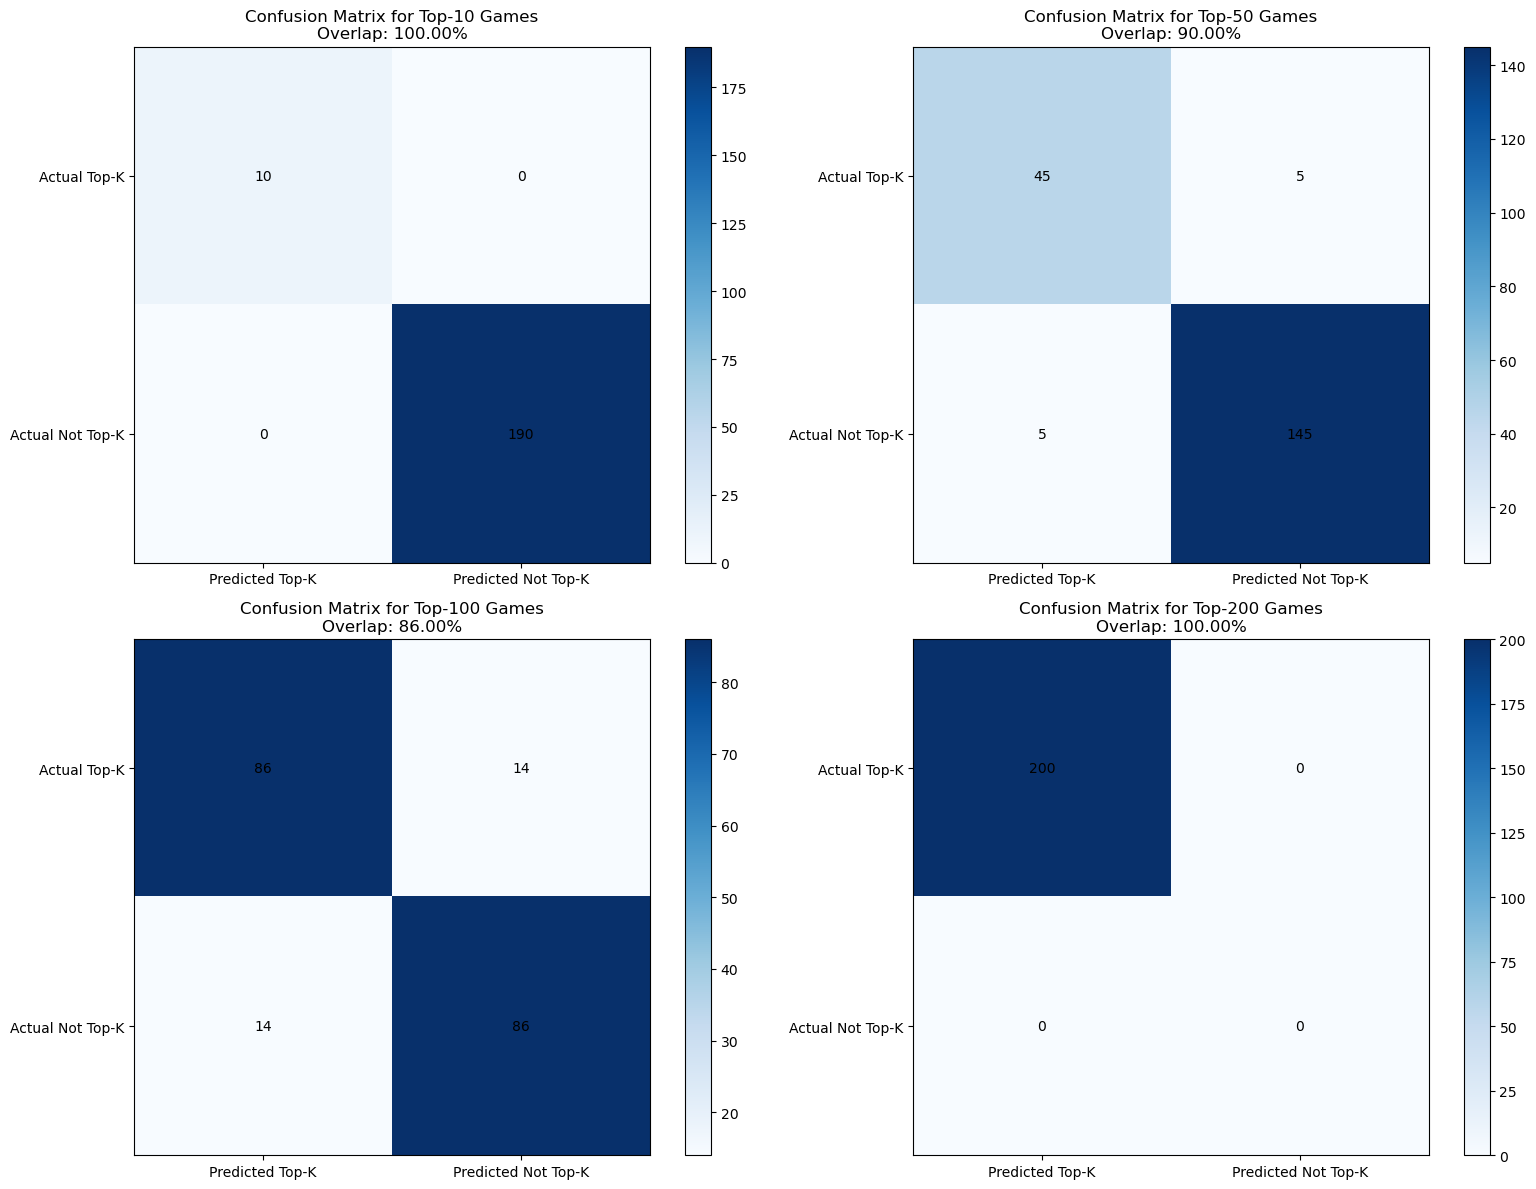


Analysis for September 2024 Top 10 Games:
Correctly Predicted: 10 games
Missed (False Negatives): 0 games
Incorrectly Included (False Positives): 0 games

Top 10 Games by Actual Hours Watched:
                     Game  Actual_Hours_Watched  Predicted_Hours_Watched  \
20927       Just Chatting          2.618696e+08             7.712336e+08   
20928   League of Legends          9.973407e+07             6.566348e+07   
20929  Grand Theft Auto V          9.097791e+07             6.311850e+07   
20930              Dota 2          6.606023e+07             4.915206e+07   
20931   World of Warcraft          5.712582e+07             4.029261e+07   
20932            VALORANT          5.690658e+07             4.251011e+07   
20933      Counter-Strike          5.613190e+07             3.941615e+07   
20934            Fortnite          4.535251e+07             3.406433e+07   
20935           Minecraft          4.188053e+07             3.016523e+07   
20936     EA Sports FC 25          3.119509e+0

<Figure size 1200x800 with 0 Axes>

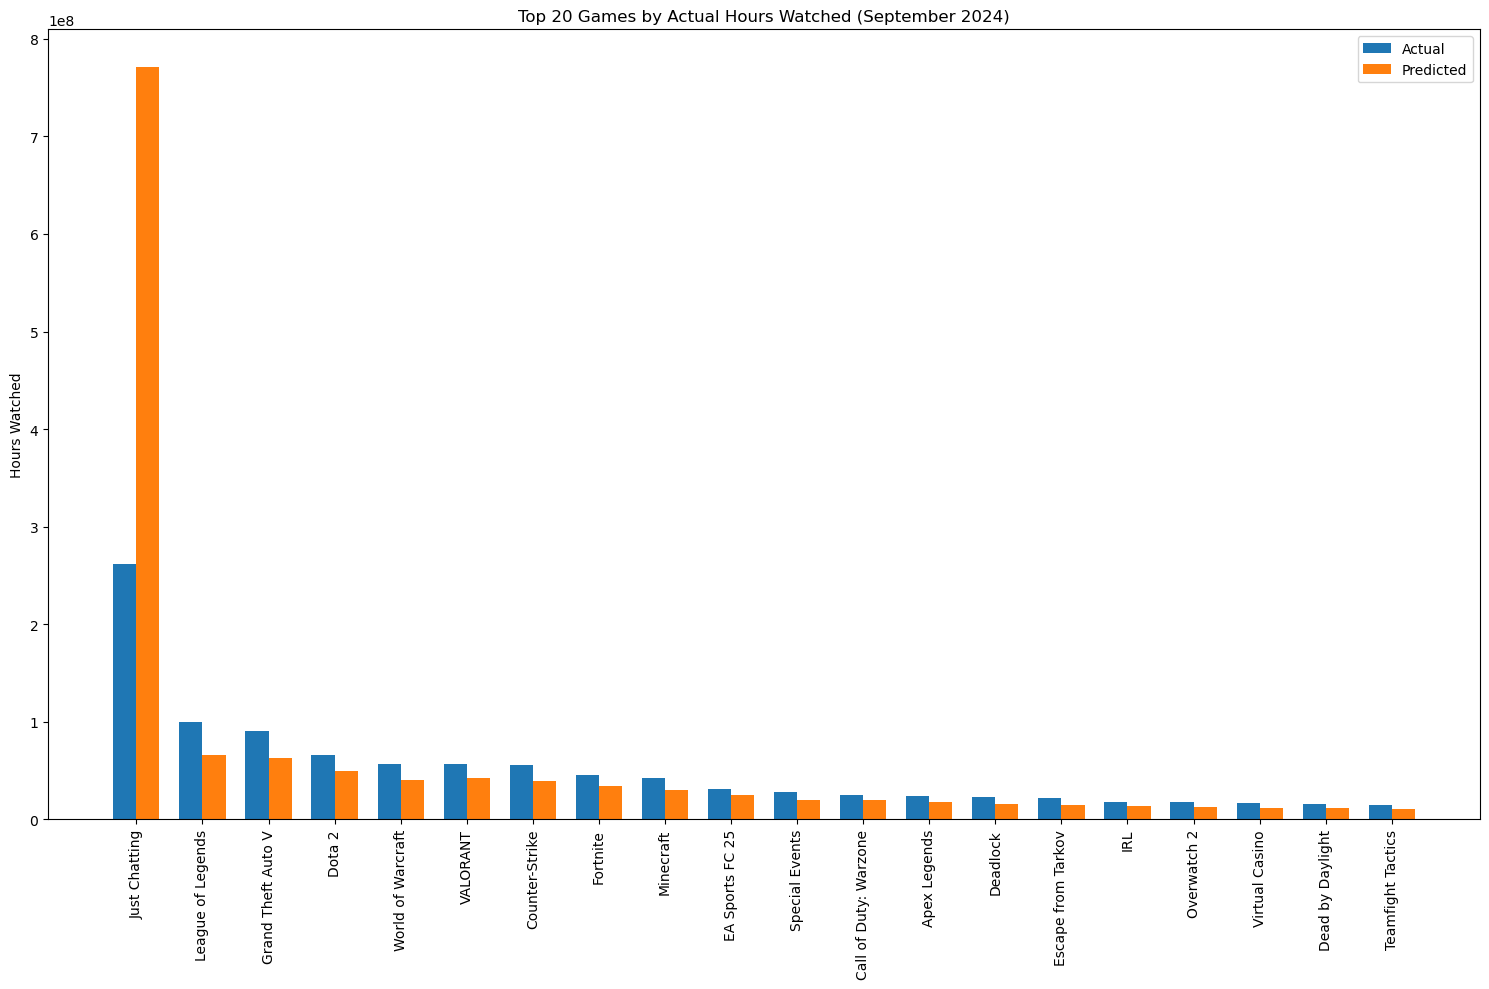

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import spearmanr

df = pd.read_csv("Twitch_game_data.csv", encoding="ISO-8859-1")
df['date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))
df = df.sort_values(by=['date']).reset_index(drop=True)

predictive_features = [
    'Hours_streamed', 'Peak_viewers', 'Peak_channels', 
    'Streamers', 'Avg_viewers', 'Avg_channels', 'Avg_viewer_ratio'
]
target = 'Hours_watched'

unique_dates = sorted(df['date'].unique())
test_dates = unique_dates[-2:]  
train_dates = unique_dates[:-2]  

train_df = df[df['date'].isin(train_dates)].copy()
test_df = df[df['date'].isin(test_dates)].copy()

print(f"Train data shape: {train_df.shape}, covering dates: {train_dates[0]} to {train_dates[-1]}")
print(f"Test data shape: {test_df.shape}, covering dates: {test_dates[0]} to {test_dates[-1]}")

feature_scaler = MinMaxScaler()
train_df[predictive_features] = feature_scaler.fit_transform(train_df[predictive_features])
test_df[predictive_features] = feature_scaler.transform(test_df[predictive_features])

target_scaler = MinMaxScaler()
train_df[target] = target_scaler.fit_transform(train_df[[target]])
test_df[target] = target_scaler.transform(test_df[[target]])

class GameDataset(Dataset):
    def __init__(self, df, features, target):
        self.features = df[features].values
        self.target = df[target].values
        
    def __len__(self):
        return len(self.features)
        
    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.target[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

class PredictionModel(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64, 32]):
        super(PredictionModel, self).__init__()
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm1d(hidden_dims[0]))
        layers.append(nn.Dropout(0.2))
        
        # Hidden layers
        for i in range(len(hidden_dims)-1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_dims[i+1]))
            layers.append(nn.Dropout(0.2))
            
        # Output layer
        layers.append(nn.Linear(hidden_dims[-1], 1))
        
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

train_dataset = GameDataset(train_df, predictive_features, target)
test_dataset = GameDataset(test_df, predictive_features, target)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

input_dim = len(predictive_features)
model = PredictionModel(input_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 50
train_losses = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    
    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses)
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

model.eval()
test_predictions = []
test_actuals = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs).squeeze()
        test_predictions.extend(outputs.cpu().numpy().tolist())
        test_actuals.extend(targets.cpu().numpy().tolist())

test_predictions = np.array(test_predictions).reshape(-1, 1)
test_actuals = np.array(test_actuals).reshape(-1, 1)

test_predictions_original = target_scaler.inverse_transform(test_predictions).flatten()
test_actuals_original = target_scaler.inverse_transform(test_actuals).flatten()

results_df = test_df.copy()
results_df['Predicted_Hours_Watched'] = test_predictions_original
results_df['Actual_Hours_Watched'] = test_actuals_original

mse = mean_squared_error(test_actuals_original, test_predictions_original)
mae = mean_absolute_error(test_actuals_original, test_predictions_original)
spearman_corr, _ = spearmanr(test_actuals_original, test_predictions_original)

print("\nTest Set Performance:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"Spearman Rank Correlation: {spearman_corr:.4f}")

plt.figure(figsize=(10, 8))
plt.scatter(test_actuals_original, test_predictions_original, alpha=0.5)
plt.plot([test_actuals_original.min(), test_actuals_original.max()],
         [test_actuals_original.min(), test_actuals_original.max()], '--r')
plt.xlabel('Actual Hours Watched')
plt.ylabel('Predicted Hours Watched')
plt.title('Actual vs. Predicted Hours Watched')
plt.grid(True)
plt.show()

def evaluate_top_k(df, k_values=[10, 50, 100, 200]):
    monthly_results = {}
    for date in df['date'].unique():
        month_df = df[df['date'] == date].copy()
        
        actual_sorted = month_df.sort_values('Actual_Hours_Watched', ascending=False).reset_index(drop=True)
        predicted_sorted = month_df.sort_values('Predicted_Hours_Watched', ascending=False).reset_index(drop=True)
        
        month_results = {}
        for k in k_values:
            actual_top_k = set(actual_sorted.head(k)['Game'])
            predicted_top_k = set(predicted_sorted.head(k)['Game'])
            TP = len(actual_top_k.intersection(predicted_top_k))
            FP = len(predicted_top_k - actual_top_k)
            FN = len(actual_top_k - predicted_top_k)
            TN = len(month_df) - (TP + FP + FN)
            
            precision = TP / (TP + FP) if (TP + FP) > 0 else 0
            recall = TP / (TP + FN) if (TP + FN) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            accuracy = (TP + TN) / (TP + TN + FP + FN)
            
            month_results[k] = {
                'TP': TP,
                'FP': FP,
                'FN': FN,
                'TN': TN,
                'Precision': precision,
                'Recall': recall,
                'F1': f1,
                'Accuracy': accuracy,
                'Overlap': TP / k if k > 0 else 0
            }
        
        monthly_results[date] = month_results
    
    return monthly_results

k_values = [10, 50, 100, 200]
monthly_performance = evaluate_top_k(results_df, k_values)

for date, results in monthly_performance.items():
    print(f"\nPerformance for {date.strftime('%B %Y')}:")
    for k, metrics in results.items():
        print(f"Top-{k} Games:")
        print(f"  Overlap: {metrics['Overlap']:.2%} ({metrics['TP']} out of {k})")
        print(f"  Precision: {metrics['Precision']:.2%}")
        print(f"  Recall: {metrics['Recall']:.2%}")
        print(f"  F1 Score: {metrics['F1']:.2%}")

most_recent_date = max(monthly_performance.keys())
most_recent_results = monthly_performance[most_recent_date]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, k in enumerate(k_values):
    metrics = most_recent_results[k]
    cm = np.array([[metrics['TP'], metrics['FP']], 
                   [metrics['FN'], metrics['TN']]])
    
    ax = axes[i]
    im = ax.imshow(cm, cmap='Blues')
    
    for i_row in range(2):
        for i_col in range(2):
            ax.text(i_col, i_row, f"{cm[i_row, i_col]}", 
                    ha="center", va="center", color="black")
    
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Predicted Top-K', 'Predicted Not Top-K'])
    ax.set_yticklabels(['Actual Top-K', 'Actual Not Top-K'])
    ax.set_title(f"Confusion Matrix for Top-{k} Games\nOverlap: {metrics['Overlap']:.2%}")
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()
recent_month_df = results_df[results_df['date'] == most_recent_date].copy()
actual_top10 = set(recent_month_df.sort_values('Actual_Hours_Watched', ascending=False).head(10)['Game'])
predicted_top10 = set(recent_month_df.sort_values('Predicted_Hours_Watched', ascending=False).head(10)['Game'])

correct_top10 = actual_top10.intersection(predicted_top10)
missed_top10 = actual_top10 - predicted_top10
false_top10 = predicted_top10 - actual_top10

print(f"\nAnalysis for {most_recent_date.strftime('%B %Y')} Top 10 Games:")
print(f"Correctly Predicted: {len(correct_top10)} games")
print(f"Missed (False Negatives): {len(missed_top10)} games")
print(f"Incorrectly Included (False Positives): {len(false_top10)} games")

top10_details = recent_month_df.sort_values('Actual_Hours_Watched', ascending=False).head(10).copy()
top10_details = top10_details[['Game', 'Actual_Hours_Watched', 'Predicted_Hours_Watched']]
top10_details['Rank_Actual'] = range(1, 11)
top10_details['Rank_Predicted'] = top10_details['Predicted_Hours_Watched'].rank(ascending=False).astype(int)
top10_details['Rank_Difference'] = top10_details['Rank_Actual'] - top10_details['Rank_Predicted']

print("\nTop 10 Games by Actual Hours Watched:")
print(top10_details)

plt.figure(figsize=(12, 8))
top20_games = recent_month_df.sort_values('Actual_Hours_Watched', ascending=False).head(20)
games = top20_games['Game'].tolist()
actual = top20_games['Actual_Hours_Watched'].tolist()
predicted = top20_games['Predicted_Hours_Watched'].tolist()

x = np.arange(len(games))
width = 0.35

fig, ax = plt.subplots(figsize=(15, 10))
rects1 = ax.bar(x - width/2, actual, width, label='Actual')
rects2 = ax.bar(x + width/2, predicted, width, label='Predicted')

ax.set_ylabel('Hours Watched')
ax.set_title(f'Top 20 Games by Actual Hours Watched ({most_recent_date.strftime("%B %Y")})')
ax.set_xticks(x)
ax.set_xticklabels(games, rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

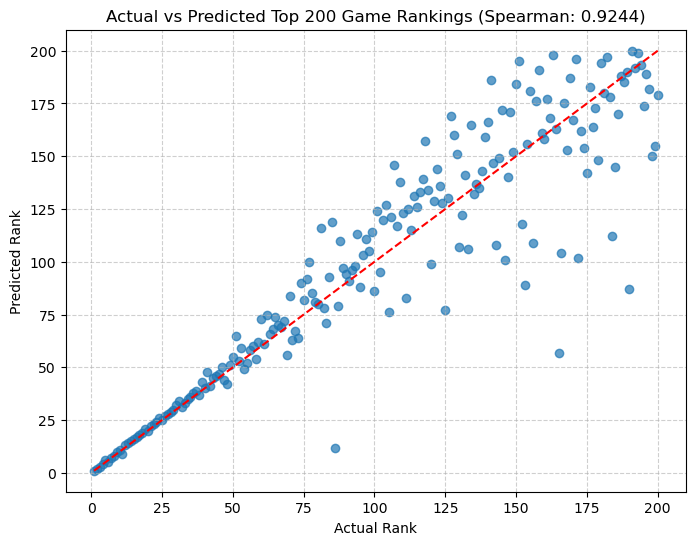

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

top_200_df = results_df.sort_values("Actual_Hours_Watched", ascending=False).head(200).copy()
top_200_df["Actual_Rank"] = np.arange(1, 201)
top_200_df = top_200_df.sort_values("Predicted_Hours_Watched", ascending=False).reset_index(drop=True)
top_200_df["Predicted_Rank"] = np.arange(1, 201)

spearman_corr, _ = spearmanr(top_200_df["Actual_Rank"], top_200_df["Predicted_Rank"])

plt.figure(figsize=(8, 6))
plt.scatter(top_200_df["Actual_Rank"], top_200_df["Predicted_Rank"], alpha=0.7)
plt.plot([1, 200], [1, 200], 'r--')
plt.xlabel("Actual Rank")
plt.ylabel("Predicted Rank")
plt.title(f"Actual vs Predicted Top 200 Game Rankings (Spearman: {spearman_corr:.4f})")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


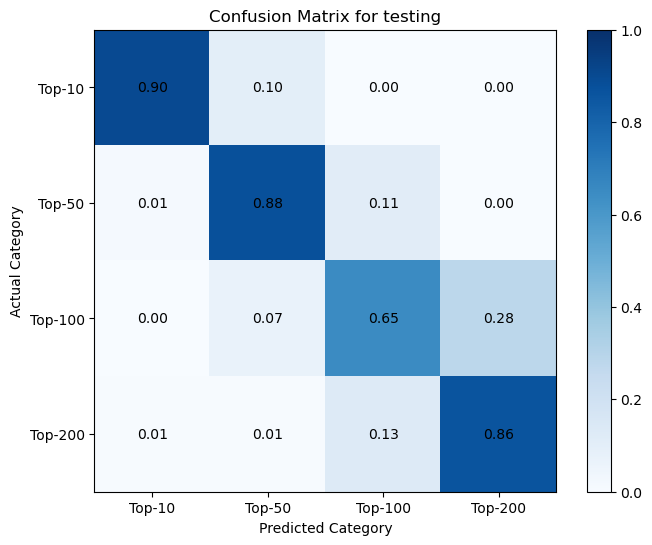

In [87]:
import numpy as np
import matplotlib.pyplot as plt

conf_matrix_4x4 = np.zeros((4, 4), dtype=int)
k_categories = {10: 0, 50: 1, 100: 2, 200: 3}
k_sizes = {10: 10, 50: 40, 100: 50, 200: 100}  

for date in test_dates:  
    month_df = results_df[results_df['date'] == date].copy()

    actual_sorted = month_df.sort_values('Actual_Hours_Watched', ascending=False).reset_index(drop=True)
    predicted_sorted = month_df.sort_values('Predicted_Hours_Watched', ascending=False).reset_index(drop=True)

    actual_labels = {}
    for k, idx in k_categories.items():
        if k == 10:
            actual_labels.update({game: idx for game in actual_sorted.head(10)['Game']})
        elif k == 50:
            actual_labels.update({game: idx for game in actual_sorted.iloc[10:50]['Game']})
        elif k == 100:
            actual_labels.update({game: idx for game in actual_sorted.iloc[50:100]['Game']})
        elif k == 200:
            actual_labels.update({game: idx for game in actual_sorted.iloc[100:200]['Game']})

    predicted_labels = {}
    for k, idx in k_categories.items():
        if k == 10:
            predicted_labels.update({game: idx for game in predicted_sorted.head(10)['Game']})
        elif k == 50:
            predicted_labels.update({game: idx for game in predicted_sorted.iloc[10:50]['Game']})
        elif k == 100:
            predicted_labels.update({game: idx for game in predicted_sorted.iloc[50:100]['Game']})
        elif k == 200:
            predicted_labels.update({game: idx for game in predicted_sorted.iloc[100:200]['Game']})

    for game in actual_labels:
        actual_idx = actual_labels[game]  
        pred_idx = predicted_labels.get(game, 3)  
        conf_matrix_4x4[actual_idx, pred_idx] += 1

conf_matrix_percentage = np.zeros_like(conf_matrix_4x4, dtype=float)

for i in range(4):
    total_actual = k_sizes[list(k_categories.keys())[i]] * len(test_dates)  
    if total_actual > 0:
        conf_matrix_percentage[i, :] = conf_matrix_4x4[i, :] / total_actual

labels = ['Top-10', 'Top-50', 'Top-100', 'Top-200']
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(conf_matrix_percentage, cmap="Blues", vmin=0, vmax=1)

for i in range(4):
    for j in range(4):
        ax.text(j, i, f"{conf_matrix_percentage[i, j]:.2f}", ha="center", va="center", color="black")
ax.set_xticks(np.arange(4))
ax.set_yticks(np.arange(4))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel("Predicted Category")
ax.set_ylabel("Actual Category")
ax.set_title("Confusion Matrix for testing")
plt.colorbar(im)
plt.show()
